In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

print('Версия pandas:', pd.__version__)

Версия pandas: 2.1.4


# Часть 2. Pivot & Pivot_table 

# Создание сводных таблиц в pandas

## Часть 2. Фрагмент 1.  
  
     - Форматы Stacked & Record
     - 1. DataFrame.pivot() и pd.pivot()
     - 2. DataFrame.pivot_table() и pd.pivot_table()
    
## Часть 2. Фрагмент 2.

    - Типичная ошибка в использовании pivot_table
    - Варианты решения и преобразование структуры DataFrame
    - Методы melt & wide_to_long

## Часть 2. Фрагмент 3.

    - Таблицы сопряженности и метод crosstab

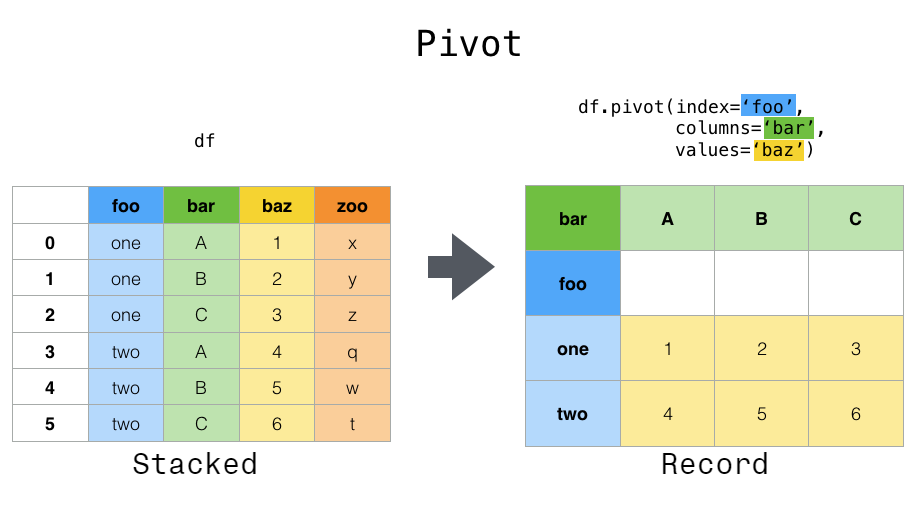

In [2]:
Image('files/stacked_record.png')

    В "record" формате обычно имеется одна строка для каждого объекта
    В формате "stacked" для каждого объекта, где это применимо, имеется несколько строк.

# 1. DataFrame.pivot() и pd.pivot()

In [3]:
df_exams=pd.read_csv('files/language_exam')
df_exams

,Name,Subject,Points,Result
0,Alice,English,89,passed
1,Alice,French,75,passed
2,Alice,Spanish,74,passed
3,Jane,English,78,passed
4,Jane,French,73,passed
5,Jane,Spanish,70,passed
6,Tom,English,63,passed
7,Tom,French,53,passed
8,Tom,Spanish,22,failed


## Пример 1.1

In [4]:
# меняем формат таблицы на 'record'

df_exams.pivot(index='Name',
              columns='Subject',
              values='Points')

Subject,English,French,Spanish
Name,,,
Alice,89,75,74
Jane,78,73,70
Tom,63,53,22


## Пример 1.2

In [5]:
# другой вариант поворота данных

df_exams.pivot(index='Subject',
              columns='Name',
              values='Result')

Name,Alice,Jane,Tom
Subject,,,
English,passed,passed,passed
French,passed,passed,passed
Spanish,passed,passed,failed


### - аргумент columns указывать обязательно!

## Пример 1.3 

In [6]:
# если не укажем аргумент columns, то получим ошибку TypeError
try:
    df_exams.pivot(index='Name',
              values='Points')
except TypeError as e:
     print("TypeError:", e)

TypeError: DataFrame.pivot() missing 1 required keyword-only argument: 'columns'


### - аргументы index и values можно не указывать

## Пример 1.4

In [7]:
# аргумент index отсутствует
# по умолчанию используются индексы изначальной структуры
df_exams.pivot(columns='Name',
              values='Result')

Name,Alice,Jane,Tom
0,passed,NaN,NaN
1,passed,NaN,NaN
2,passed,NaN,NaN
3,NaN,passed,NaN
4,NaN,passed,NaN
5,NaN,passed,NaN
6,NaN,NaN,passed
7,NaN,NaN,passed
8,NaN,NaN,failed


## Пример 1.5

In [8]:
# если не укажем аргумент values, то будут использованы все оставшиеся столбцы
# в нашем случае это приведет к созданию иерархического индекса
df_exams.pivot(index='Name',
               columns='Subject')

Points                 Result                
Subject English French Spanish English  French Spanish
Name                                                  
Alice        89     75      74  passed  passed  passed
Jane         78     73      70  passed  passed  passed
Tom          63     53      22  passed  passed  failed

# Функция pd.pivot()

### Параметры pd.pivot():

    - data - исходный DataFrame

    - columns - столбец, используемый для создания столбцов нового DataFrame. 

    - index = no_default - столбец, используемый для создания индекса нового DataFrame.
      Если не указано, то будет использоваться существующий индекс. 

    - values = no_default - столбцы, используемые для заполнения значений нового DataFrame. 
      Если не указано, то будут использованы все оставшиеся столбцы, 
      а результат будет иметь иерархически индексированные столбцы.

## Пример 1.6

In [9]:
# используем функцию pd.pivot()

pd.pivot(df_exams,
         index='Subject',
         columns='Name',
         values='Result')

Name,Alice,Jane,Tom
Subject,,,
English,passed,passed,passed
French,passed,passed,passed
Spanish,passed,passed,failed


### - DataFrame.pivot(), также как и pd.pivot(), может обрабатывать только уникальные строки

In [10]:
# создаем новый DataFrame, добавляем дубликаты строк

df_exams_d=pd.concat([df_exams, df_exams.iloc[[3,8]]], 
                     ignore_index=True)
df_exams_d

,Name,Subject,Points,Result
0,Alice,English,89,passed
1,Alice,French,75,passed
2,Alice,Spanish,74,passed
3,Jane,English,78,passed
4,Jane,French,73,passed
5,Jane,Spanish,70,passed
6,Tom,English,63,passed
7,Tom,French,53,passed
8,Tom,Spanish,22,failed
9,Jane,English,78,passed


## Пример 1.7

In [11]:
# DataFrame.pivot() может обрабатывать только уникальные строки
# Если данные содержат дубликаты, то нужно использовать DataFrame.pivot_table()
# Поднимает ValueError если есть любые комбинации индексов, столбцов с несколькими значениями.

try:
    df_exams_d.pivot(index='Name',
              columns='Subject',
              values='Points')
except ValueError as e:
     print("ValueError:", e)

ValueError: Index contains duplicate entries, cannot reshape


## DataFrame.pivot() и pd.pivot()

    Функция pandas.pivot() / метод DataFrame.pivot()...
    
    - изменяет форму таблицы на основе значений индекса/столбцов
    - использует УНИКАЛЬНЫЕ значения из указанного индекса/столбцов для формирования осей результирующего объекта DataFrame
    - Возвращает измененный DataFrame, организованный по заданным значениям индекса/столбца
    - Не воспринимает MultiIndex (работает только с нулевым уровнем индекса)
    - не поддерживает агрегацию данных

    1. DataFrame.pivot() или pd.pivot() 
    создает сводную таблицу общего назначения с различными типами данных
    
    2. DataFrame.pivot_table() или pd.pivot_table() 
    используется для создания для сводной таблицы с агрегированием числовых данных
    (можно использовать для создания сводных таблиц в стиле электронных таблиц Excel)

# 2. DataFrame.pivot_table() и pd.pivot_table()

_Функция pandas.pivot_table() и метод DataFrame.pivot_table() создает сводную таблицу в стиле электронной таблицы Excel в виде DataFrame._

    Синтаксис pivot_table()

    df.pivot_table(values=None, index=None, columns=None, aggfunc='mean', fill_value=None, dropna=True)

    index: столбец для использования в качестве меток строк
    columns: столбец, который будет преобразован в columns
    values: столбцы, которые будут использоваться для значений нового датафрейма
    aggfunc: функция, используемая для агрегирования, по умолчанию - 'mean'
    fill_value: на какие значения будут заменены отсутствующие значения
    dropna: следует ли исключать столбцы, все записи которых являются NaN

In [12]:
df_exams_d

,Name,Subject,Points,Result
0,Alice,English,89,passed
1,Alice,French,75,passed
2,Alice,Spanish,74,passed
3,Jane,English,78,passed
4,Jane,French,73,passed
5,Jane,Spanish,70,passed
6,Tom,English,63,passed
7,Tom,French,53,passed
8,Tom,Spanish,22,failed
9,Jane,English,78,passed


## Пример 2.1

In [13]:
# с дубликатами

df_exams_d.pivot_table(values='Points', index='Subject') 

,Points
Subject,
English,77.0
French,67.0
Spanish,47.0


In [14]:
# допустим, что мы не знаем, есть ли дубликаты
# можем проверить на наличие дубликатов и посчитать количество дубликатов
display(df_exams_d.duplicated(),
        df_exams_d.duplicated().sum())

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
dtype: bool

2

In [15]:
display(df_exams_d.drop_duplicates()) # убираем дубликаты, возвращается новый объект
df_exams_d.drop_duplicates(inplace=True) # убираем дубликаты, сохраняем изменения в изначальной структуре

,Name,Subject,Points,Result
0,Alice,English,89,passed
1,Alice,French,75,passed
2,Alice,Spanish,74,passed
3,Jane,English,78,passed
4,Jane,French,73,passed
5,Jane,Spanish,70,passed
6,Tom,English,63,passed
7,Tom,French,53,passed
8,Tom,Spanish,22,failed


## Пример 2.2

In [16]:
# уже без дубликатов
# для агрегации используем колонку с числовым типом данных
# по умолчанию агрегирующая функция - среднее значение ('mean')
df_exams_d.pivot_table(values='Points', index='Subject')

,Points
Subject,
English,76.666667
French,67.000000
Spanish,55.333333


## Пример 2.3

In [17]:
# обратите внимание на тип данных колонки, передаваемой в values!
try:
    df_exams_d.pivot_table(values='Result', index='Subject')
except TypeError as e:
     print("TypeError:", e)

TypeError: agg function failed [how->mean,dtype->object]


## Пример 2.4.1

In [18]:
# без дубликатов
# можно использовать колонки с нечисловым типом данных в values, если нужно посчитать количество значений
df_exams_d.pivot_table(index='Result', values='Name', columns='Subject', aggfunc='count') 

Subject,English,French,Spanish
Result,,,
failed,NaN,NaN,1.0
passed,3.0,3.0,2.0


## Пример 2.4.2

In [19]:
# ставим "0" вместо NaN

df_exams_d.pivot_table(index='Result', values='Name', columns='Subject', aggfunc='count', fill_value=0) 

Subject,English,French,Spanish
Result,,,
failed,0,0,1
passed,3,3,2


## Пример 2.5.1

In [20]:
df_exams.pivot_table(values='Points', index='Subject', columns='Name')

Name,Alice,Jane,Tom
Subject,,,
English,89.0,78.0,63.0
French,75.0,73.0,53.0
Spanish,74.0,70.0,22.0


## Пример 2.5.2

In [21]:
df_exams_2=pd.concat([df_exams, pd.DataFrame([['Tom', 'Spanish', 50, 'passed']], 
                                             columns=['Name', 'Subject', 'Points', 'Result'])], 
                     ignore_index=True)
display(df_exams_2, 
        df_exams_2.pivot_table(values='Points', index='Subject', columns='Name'))

,Name,Subject,Points,Result
0,Alice,English,89,passed
1,Alice,French,75,passed
2,Alice,Spanish,74,passed
3,Jane,English,78,passed
4,Jane,French,73,passed
5,Jane,Spanish,70,passed
6,Tom,English,63,passed
7,Tom,French,53,passed
8,Tom,Spanish,22,failed
9,Tom,Spanish,50,passed


Name,Alice,Jane,Tom
Subject,,,
English,89.0,78.0,63.0
French,75.0,73.0,53.0
Spanish,74.0,70.0,36.0


## Пример 2.5.3

In [22]:
df_exams.pivot(values='Points', index='Subject', columns='Name')

Name,Alice,Jane,Tom
Subject,,,
English,89,78,63
French,75,73,53
Spanish,74,70,22


## Пример 2.6

In [23]:
# добавляем промежуточные итоги - margins=True

display(df_exams.pivot_table(values='Points', index='Subject', columns='Name', ),
        df_exams.pivot_table(values='Points', index='Subject', columns='Name', margins=True).round(2))

Name,Alice,Jane,Tom
Subject,,,
English,89.0,78.0,63.0
French,75.0,73.0,53.0
Spanish,74.0,70.0,22.0


Name,Alice,Jane,Tom,All
Subject,,,,
English,89.00,78.00,63.0,76.67
French,75.00,73.00,53.0,67.00
Spanish,74.00,70.00,22.0,55.33
All,79.33,73.67,46.0,66.33


## Пример 2.7

In [24]:
# заменяем метку 'All' на 'mean', что  отражает суть - margins_name='mean'

df_exams.pivot_table(values='Points', index='Subject', columns='Name', margins=True, margins_name='mean').round(2)

Name,Alice,Jane,Tom,mean
Subject,,,,
English,89.00,78.00,63.0,76.67
French,75.00,73.00,53.0,67.00
Spanish,74.00,70.00,22.0,55.33
mean,79.33,73.67,46.0,66.33


## Работа с отсутствующими значениями NaN

## Пример 2.8.1

In [25]:
# создаем новый DataFrame
# добавляем данные студента по имени Alex, который не сдал ни одного экзамена

df_exams_3=pd.concat([df_exams, pd.DataFrame([['Alex','English', np.nan, 'failed'],
                                             ['Alex','French', np.nan, 'failed'],
                                              ['Alex','Spanish', np.nan, 'failed'],
                                              ['Alex','German', np.nan, 'failed']],
                                             columns=['Name', 'Subject', 'Points', 'Result'])], 
                     ignore_index=True)
df_exams_3

,Name,Subject,Points,Result
0,Alice,English,89.0,passed
1,Alice,French,75.0,passed
2,Alice,Spanish,74.0,passed
3,Jane,English,78.0,passed
4,Jane,French,73.0,passed
5,Jane,Spanish,70.0,passed
6,Tom,English,63.0,passed
7,Tom,French,53.0,passed
8,Tom,Spanish,22.0,failed
9,Alex,English,NaN,failed


In [26]:
# по умолчанию из результата исключаются все строки и столбцы, содержащие только значения NaN
df_exams_3.pivot_table(values='Points', index='Subject', columns='Name', 
                               margins=True, margins_name='mean').round(2)

Name,Alice,Jane,Tom,mean
Subject,,,,
English,89.00,78.00,63.0,76.67
French,75.00,73.00,53.0,67.00
Spanish,74.00,70.00,22.0,55.33
mean,79.33,73.67,46.0,66.33


## Пример 2.8.2 - dropna=False

In [27]:
# Чтобы оставить в результате строки/столбцы, содержащие только NaN надо прописать dropna=False  
df_exams_3.pivot_table(values='Points', index='Subject', columns='Name',
                       dropna=False, margins=True, margins_name='mean').round(2)

Name,Alex,Alice,Jane,Tom,mean
Subject,,,,,
English,NaN,89.00,78.00,63.0,76.67
French,NaN,75.00,73.00,53.0,67.00
German,NaN,NaN,NaN,NaN,NaN
Spanish,NaN,74.00,70.00,22.0,55.33
mean,NaN,79.33,73.67,46.0,66.33


## Пример 2.9 - sort=False

In [28]:
df_exams_3.pivot_table(values='Points', index='Subject', columns='Name', 
                       margins=True, margins_name='mean', sort=False).round(2)

Name,Alice,Jane,Tom,mean
Subject,,,,
English,89.00,78.00,63.0,76.67
French,75.00,73.00,53.0,67.00
Spanish,74.00,70.00,22.0,55.33
mean,79.33,73.67,46.0,66.33


## Используем список или словарь для применения нескольких агрегирующих функций

## Пример 2.10 - несколько агрегирующих функций для одного столбца

In [29]:
# две агрегации - среднее и максимальное значение по колонке 'Points'

display(df_exams_3.pivot_table(values='Points', index='Subject', aggfunc=['mean', 'max']).round(2))

# результат с итогами - средний балл по всем предметам и максимальный балл по языковому экзамену

display(df_exams_3.pivot_table(values='Points', index='Subject', aggfunc=['mean', 'max'], margins=True).round(2))

,mean,max
,Points,Points
Subject,,
English,76.67,89.0
French,67.00,75.0
Spanish,55.33,74.0


,mean,max
,Points,Points
Subject,,
English,76.67,89.0
French,67.00,75.0
Spanish,55.33,74.0
All,66.33,89.0


#### 1. Если передается список агрегирующих функций, то результирующая сводная таблица будет иметь иерархические столбцы, верхним уровнем которых являются имена функций. 

#### 2. Если передается словарь dict, то ключом для агрегирования является столбец, а значением - агрегирующая функция или их список

## Пример 2.11 - разные агрегирующие функции для разных столбцов

In [30]:
df_exams_3.pivot_table(values=['Points', 'Name'], 
                       index='Subject', 
                       aggfunc={'Points':'mean', 'Name':'count'}).round(2)

,Name,Points
Subject,,
English,4,76.67
French,4,67.00
German,1,NaN
Spanish,4,55.33


## Пример 2.12 - 
### две агрегирующие функции для одного столбца + одна агрегирующая функция - для другого столбца

In [31]:
df_exams_3.pivot_table(values=['Points', 'Name'], 
                       index='Subject', 
                       aggfunc={'Points':['mean', 'max'], 'Name':'count'}).round(2)

Name Points       
        count    max   mean
Subject                    
English     4   89.0  76.67
French      4   75.0  67.00
German      1    NaN    NaN
Spanish     4   74.0  55.33

### Далее...

### Часть 2. Фрагмент 2. 

    - Типичная ошибка в использовании pivot_table
    - Варианты решения и преобразование структуры DataFrame
    - Методы melt & wide_to_long
    
### Часть 2. Фрагмент 3.

    - Таблицы сопряженности и метод crosstab